In [1]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
from scipy.stats import multivariate_t as mvt

sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg

In [2]:
prec_1 = np.array([[ 1.51515152,  0.        , -1.06060606,  0.55151515],
                    [ 0.        ,  2.5       ,  0.        ,  0.        ],
                    [-1.06060606,  0.        ,  4.24242424, -0.60606061],
                    [ 0.55151515,  0.        , -0.60606061,  1.51515152]])

prec_2 = np.array([[ 1.51515152,  0.        , -1.06060606,  0.0],
                    [ 0.        ,  2.5       ,  0.        ,  0.        ],
                    [-1.06060606,  0.        ,  4.24242424, -0.60606061],
                    [ 0.0,  0.        , -0.60606061,  1.51515152]])

             

# Parallel test

## Student t

Error 1.00E-6:  73%|███████▎  | 733/1000 [00:03<00:01, 201.83it/s]


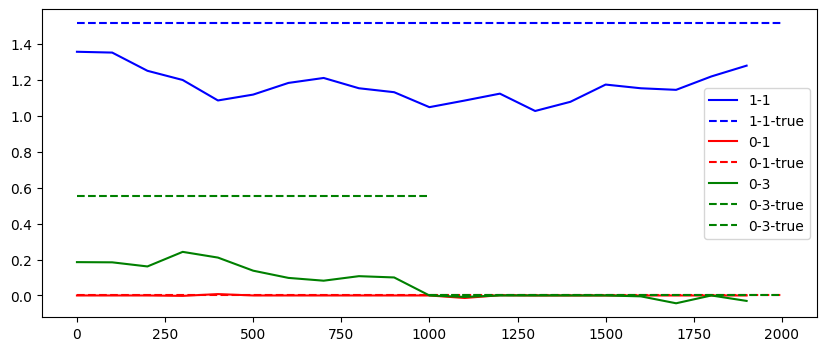

In [8]:

n = 1000
X1 = mvt.rvs(shape = np.linalg.inv(prec_1),  df = 4, size = n)
X2 = mvt.rvs(shape = np.linalg.inv(prec_2),  df = 4, size = n)
X = np.vstack((X1,X2))
X.shape    
obs_per_graph = 100
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 1000, lamda = obs_per_graph*0.1, kappa = obs_per_graph*0.4, tol = 1e-6)
dg_opt1.fit(X, nr_workers=7, temporal_penalty="ridge", lik_type="t", nr_em_itr = 100, time_index=range(X.shape[0]), nu = 4)


fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,0], label = "1-1", color = 'blue')
#ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,0], color = 'lightblue')
ax.plot([0, X.shape[0]-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,1], label = "0-1", color = 'red')
# ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,1], color = '#ff5971')
ax.plot([0, X.shape[0]-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
# ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,3], color = 'lightgreen')
ax.plot([0, n-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([n, 2*n-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

ax.legend()


## Gaussian

Error 1.00E-6:  64%|██████▍   | 644/1000 [00:03<00:01, 195.11it/s]


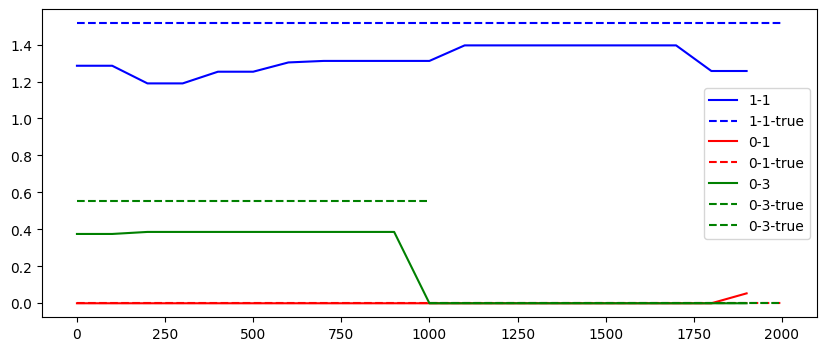

In [7]:
from scipy.stats import multivariate_t as mvt
n = 1000
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
obs_per_graph = 100  
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 1000, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.1, tol = 1e-6)
dg_opt1.fit(X, nr_workers=7, temporal_penalty="element-wise", lik_type="gaussian", time_index=range(X.shape[0]))


fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,0], label = "1-1", color = 'blue')
#ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,0], color = 'lightblue')
ax.plot([0, X.shape[0]-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,1], label = "0-1", color = 'red')
# ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,1], color = '#ff5971')
ax.plot([0, X.shape[0]-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
# ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,3], color = 'lightgreen')
ax.plot([0, n-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([n, 2*n-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

ax.legend()


# Gaussian likelihood

### Vanilla glasso sklearn

In [ ]:
n = 1000
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
X.shape    
from sklearn.covariance import GraphicalLasso
cov = GraphicalLasso(alpha = 0.01).fit(X[:1000])
cov.precision_

array([[ 1.45403064, -0.05780811, -0.98113388,  0.38527548],
       [-0.05780811,  2.45642374, -0.        ,  0.        ],
       [-0.98113388, -0.        ,  4.30993925, -0.46365129],
       [ 0.38527548,  0.        , -0.46365129,  1.38970674]])

## Element-wise

### Estimation with multible observations per block

Error 8.62E-2:  99%|█████████▉| 99/100 [00:00<00:00, 373.45it/s]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:322: UserWarning: Max iterations reached.
  warnings.warn("Max iterations reached.")
Error 8.56E-2: 100%|██████████| 100/100 [00:00<00:00, 401.52it/s]


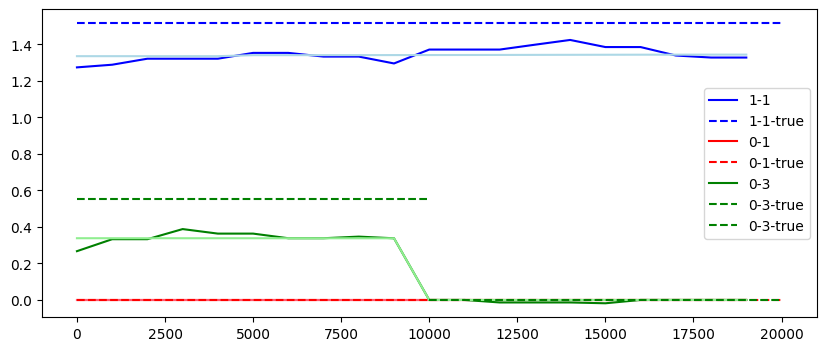

In [12]:
n = 10000
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
X.shape    

obs_per_graph = 1000
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.01, tol = 1e-6)
dg_opt1.fit(X,'element-wise', time_index=range(X.shape[0]))

dg_opt2 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.1, tol = 1e-6)
dg_opt2.fit(X,'element-wise', time_index=range(X.shape[0]))

fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,0], label = "1-1", color = 'blue')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,0], color = 'lightblue')
ax.plot([0, X.shape[0]-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,1], label = "0-1", color = 'red')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,1], color = '#ff5971')
ax.plot([0, X.shape[0]-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,3], color = 'lightgreen')
ax.plot([0, n-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([n, 2*n-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

ax.legend()


## rank 1 update

Error 1.68E-2: 100%|██████████| 100/100 [00:00<00:00, 1162.52it/s]


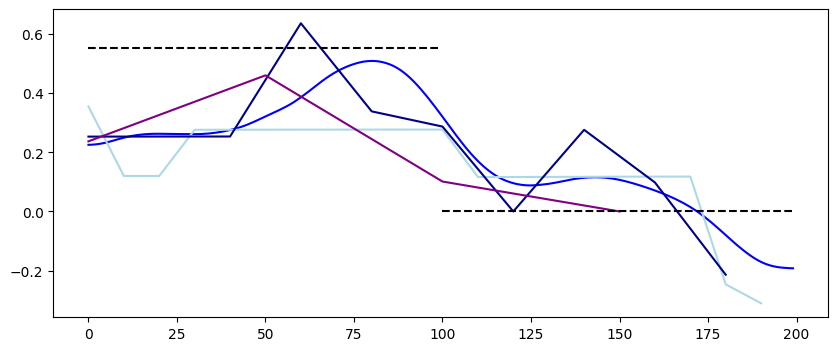

In [36]:
n = 100
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
X.shape    

dg_opt1 = dg.dygl_parallel(obs_per_graph = 1, max_iter = 100, lamda = 0.05, kappa = 5, tol = 1e-6)
dg_opt1.fit(X,'element-wise', time_index= list(range(X.shape[0])))

dg_opt2 = dg.dygl_parallel(obs_per_graph = 10, max_iter = 100, lamda = 10*0.05, kappa = 10*0.1, tol = 1e-6)
dg_opt2.fit(X,'element-wise', time_index= list(range(X.shape[0])))

dg_opt3 = dg.dygl_parallel(obs_per_graph = 20, max_iter = 100, lamda = 20*0.05, kappa = 20*0.01, tol = 1e-6)
dg_opt3.fit(X,'element-wise', time_index= list(range(X.shape[0])))

dg_opt4 = dg.dygl_parallel(obs_per_graph = 50, max_iter = 100, lamda = 50*0.05, kappa = 50*0.01, tol = 1e-6)
dg_opt4.fit(X,'element-wise', time_index= list(range(X.shape[0])))

fig, ax = plt.subplots(1,1, figsize = (10,4))

i = 0
j = 3
ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,i,j], label = f"{i}-{j}", color = 'blue')
ax.plot(dg_opt2.graph_time,dg_opt2.theta[:,i,j], label = f"{i}-{j}", color = 'lightblue')
ax.plot(dg_opt3.graph_time,dg_opt3.theta[:,i,j], label = f"{i}-{j}", color = 'darkblue')
ax.plot(dg_opt4.graph_time,dg_opt4.theta[:,i,j], label = f"{i}-{j}", color = 'purple')
#ax.plot(range(dg_opt2.nr_graphs),dg_opt2.theta[:,0,0], color = 'lightblue')
ax.plot([0, n-1], [prec_1[i,j], prec_1[i,j]], label = f"{i}-{j}-true", color = 'black', linestyle = '--')
ax.plot([n, 2*n-1], [prec_2[i,j], prec_2[i,j]], label = f"{i}-{j}-true", color = 'black', linestyle = '--')

#ax.plot(range(dg_opt1.nr_graphs),dg_opt1.theta[:,0,1], label = "0-1", color = 'red')
#ax.plot(range(dg_opt2.nr_graphs),dg_opt2.theta[:,0,1], color = '#ff5971')
#ax.plot([0, dg_opt1.nr_graphs-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

#ax.plot(range(dg_opt1.nr_graphs),dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
#ax.plot(range(dg_opt2.nr_graphs),dg_opt2.theta[:,0,3], color = 'lightgreen')
#ax.plot([0, dg_opt1.nr_graphs/2-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
#ax.plot([dg_opt1.nr_graphs/2, dg_opt1.nr_graphs-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

#ax.legend()
#ax.set_xlim([0, dg_opt1.nr_graphs+5])

## Global reconstruction

Error 7.37E-2: 100%|██████████| 100/100 [00:00<00:00, 383.06it/s]


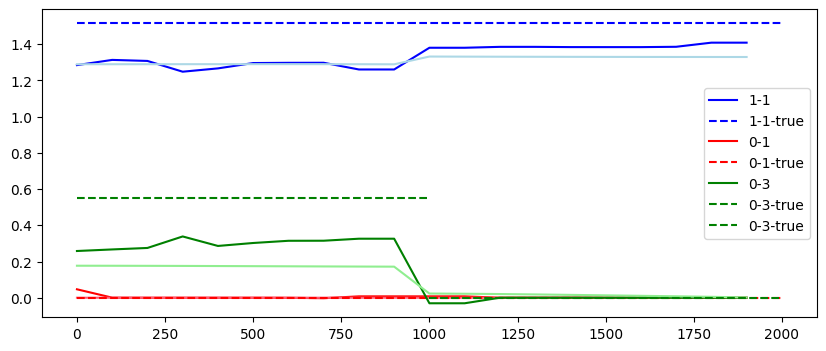

In [37]:
n = 1000
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
X.shape    

obs_per_graph = 100
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.1, tol = 1e-6)
dg_opt1.fit(X,'global-reconstruction', time_index=range(X.shape[0]))

dg_opt2 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*0.05, kappa = obs_per_graph*1, tol = 1e-6)
dg_opt2.fit(X,'global-reconstruction', time_index=range(X.shape[0]))

fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,0], label = "1-1", color = 'blue')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,0], color = 'lightblue')
ax.plot([0, X.shape[0]-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,1], label = "0-1", color = 'red')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,1], color = '#ff5971')
ax.plot([0, X.shape[0]-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,3], color = 'lightgreen')
ax.plot([0, n-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([n, 2*n-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

ax.legend()


## Ridge

Error 1.24E-1: 100%|██████████| 100/100 [00:00<00:00, 404.77it/s]


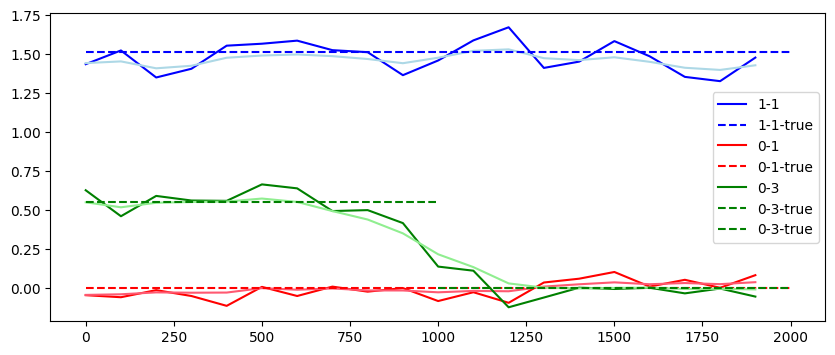

In [38]:
n = 1000
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
X.shape    

obs_per_graph = 100
dg_opt1 = dg.dygl_parallel(obs_per_graph = 100, max_iter = 100, lamda = obs_per_graph*0.01, kappa = obs_per_graph*0.1, tol = 1e-6)
dg_opt1.fit(X,'ridge', time_index=range(X.shape[0]))

dg_opt2 = dg.dygl_parallel(obs_per_graph = 100, max_iter = 100, lamda = obs_per_graph*0.01, kappa = obs_per_graph*1, tol = 1e-6)
dg_opt2.fit(X,'ridge', time_index=range(X.shape[0]))

fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,0], label = "1-1", color = 'blue')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,0], color = 'lightblue')
ax.plot([0, X.shape[0]-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,1], label = "0-1", color = 'red')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,1], color = '#ff5971')
ax.plot([0, X.shape[0]-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,3], color = 'lightgreen')
ax.plot([0, n-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([n, 2*n-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

ax.legend()

## Block-Wise reconstruction

Error 1.11E-1:  99%|█████████▉| 99/100 [00:07<00:00, 12.60it/s]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:322: UserWarning: Max iterations reached.
  warnings.warn("Max iterations reached.")
Error 1.09E-1: 100%|██████████| 100/100 [00:01<00:00, 57.26it/s]


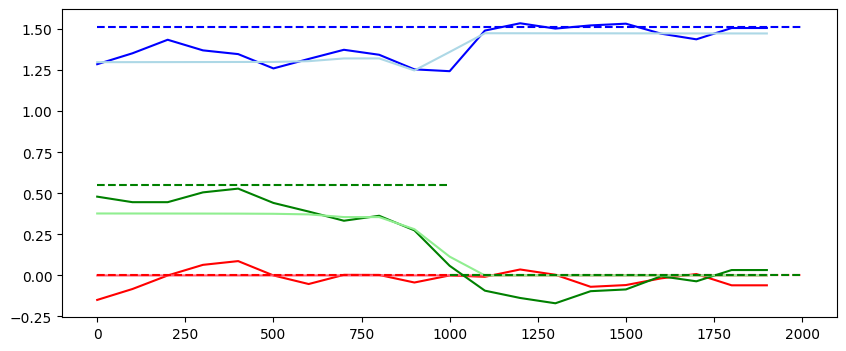

In [4]:
n = 1000
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
X.shape    

obs_per_graph = 100
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*0.01, kappa = obs_per_graph*0.1, tol = 1e-6)
dg_opt1.fit(X,'block-wise-reconstruction', time_index=range(X.shape[0]))

dg_opt2 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*0.01, kappa = obs_per_graph*0.5, tol = 1e-6)
dg_opt2.fit(X,'block-wise-reconstruction', time_index=range(X.shape[0]))

fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,0], label = "1-1", color = 'blue')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,0], color = 'lightblue')
ax.plot([0, X.shape[0]-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,1], label = "0-1", color = 'red')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,1], color = '#ff5971')
ax.plot([0, X.shape[0]-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,3], color = 'lightgreen')
ax.plot([0, n-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([n, 2*n-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

## Perturbed Node

Error 1.24E-1: 100%|██████████| 100/100 [00:04<00:00, 23.18it/s]


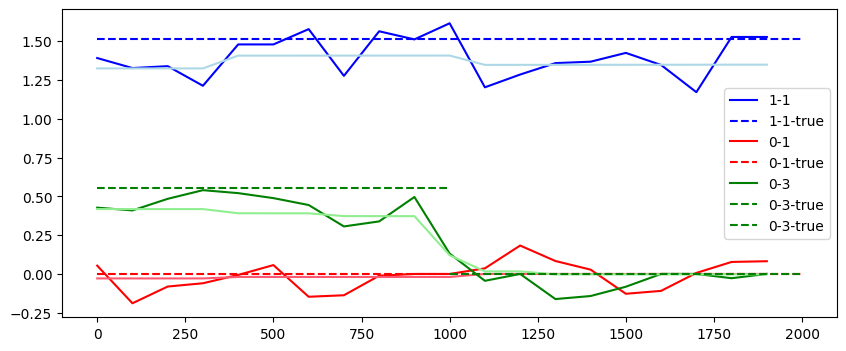

In [7]:
n = 1000
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
X.shape    

obs_per_graph = 100
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*0.01, kappa = obs_per_graph*0.1, tol = 1e-6)
dg_opt1.fit(X,'perturbed-node', time_index=range(X.shape[0]))

dg_opt2 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*0.01, kappa = obs_per_graph*1, tol = 1e-6)
dg_opt2.fit(X,'perturbed-node', time_index=range(X.shape[0]))

fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,0], label = "1-1", color = 'blue')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,0], color = 'lightblue')
ax.plot([0, X.shape[0]-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,1], label = "0-1", color = 'red')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,1], color = '#ff5971')
ax.plot([0, X.shape[0]-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,3], color = 'lightgreen')
ax.plot([0, n-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([n, 2*n-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

ax.legend()

# Large precision

Use emprical log-return precuision

In [ ]:

import requests
import pandas as pd
import bs4 


def get_wiki_ticker():
    wiki_page = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies").text
    soup = bs4.BeautifulSoup(wiki_page, 'html.parser')
    table = soup.find("table", {"class":"wikitable sortable"})

    ticker = []
    Sector = []
    SubSector = []
    HqLocation = []
    Founded = []

    # First row is header
    for row in table.findAll('tr')[1:]:
        ticker.append(row.findAll('td')[0].text)
        Sector.append(row.findAll('td')[3].text)
        SubSector.append(row.findAll('td')[4].text)
        HqLocation.append(row.findAll('td')[5].text)
        Founded.append(row.findAll('td')[8].text)

    ticker = list(map(lambda s: s.strip(), ticker))
    Founded = list(map(lambda s: s.strip(), Founded))

    ticker = pd.DataFrame(ticker,columns=['ticker'])
    sector = pd.DataFrame(Sector,columns=['sector'])
    subSector = pd.DataFrame(SubSector,columns=['subSector'])
    hqLocation = pd.DataFrame(HqLocation,columns=['hqLocation'])
    founded = pd.DataFrame(Founded,columns=['founded'])



    return  pd.concat([ticker, sector, subSector, hqLocation,founded],axis=1)

In [ ]:
ticker_data = get_wiki_ticker()

In [ ]:

def get_yh_price(ticker_list, start_period = '1052125800', interval = '1wk'):
    
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    
    dataframes_price = []

    for i, ticker in enumerate(ticker_list):
        print(f'{i} of {ticker_list.shape[0]-1}')

        # Price data
        url_price = f"http://query2.finance.yahoo.com/v8/finance/chart/{ticker}?symbol={ticker}&period1={start_period}&period2=9999999999&interval={interval}"
        response = requests.get(url_price, headers=headers)
        if response.ok:
            try:
                dates = pd.DataFrame({'timestamp':response.json()["chart"]["result"][0]["timestamp"]})

                #low, open ,volume, close, high
                df_quote = pd.DataFrame(response.json()["chart"]["result"][0]["indicators"]["quote"][0])
                # ad_close
                df_adjclose = pd.DataFrame(response.json()["chart"]["result"][0]["indicators"]["adjclose"][0])

                tmp_df_price = pd.concat([dates, df_quote,df_adjclose], axis=1)
                tmp_df_price['timestamp'] = pd.to_datetime(tmp_df_price['timestamp'], unit = "s")

            except TypeError:
                continue
            except KeyError:
                continue

            tmp_df_price["ticker"] = ticker
            dataframes_price.append(tmp_df_price)

    df_price = pd.concat(dataframes_price)

    return  df_price




In [ ]:
# df_price = get_yh_price(ticker_data['ticker'], interval = '1d',start_period= 1552311000)
# df_price['timestamp'] = pd.to_datetime(df_price['timestamp'])
# df_price['date'] = df_price['timestamp'].dt.date
# df_price['return'] = df_price.groupby(['ticker']).adjclose.pct_change()
# price_pivot = df_price[['ticker', 'return', 'timestamp']].copy()
# price_pivot['return'] = np.log(1 + price_pivot['return'])
# price_pivot = price_pivot.dropna()  # Drop rows which contain missing values
# price_pivot = pd.pivot_table(price_pivot, values = 'return', index = 'timestamp', columns= 'ticker')
# import pickle
# with open('price_pivot.pkl', 'wb') as handle:
#     pickle.dump(price_pivot, handle, protocol=pickle.HIGHEST_PROTOCOL)

0.24213449348807375

In [3]:
import pickle
with open('price_pivot.pkl', 'rb') as handle:
    price_pivot = pickle.load(handle)

In [7]:
S = np.array(price_pivot.iloc[:,:10].corr())
u,v = np.linalg.eigh(S)
u[u<=0] = 0.01
S = np.dot(v,np.diag(u)).dot(v.T)
theta = np.linalg.inv(S)
theta[np.abs(theta)<0.1] = 0  # make precision sparse
np.sum(theta == 0)/(theta.shape[0]**2)


0.3

In [8]:
theta[0,:10]

array([ 2.27114458,  0.        ,  0.        , -0.38686525, -0.12091224,
        0.        , -0.25505181, -0.63583647, -0.18614368, -0.54732006])

## Generate Guassian with this precision matrix and estimate

In [9]:
# Generate Guassian with this precision matrix and estimate
n = 10000
X1 = np.random.multivariate_normal(mean = np.zeros(theta.shape[0]),cov = np.linalg.inv(theta), size = n)
X = X1
obs_per_graph = 1000    
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 1000, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.05, tol = 1e-6)
dg_opt1.fit(X, nr_workers=10, temporal_penalty="ridge", lik_type="gaussian")

Error 1.03E-6:  33%|███▎      | 334/1000 [00:01<00:03, 202.75it/s]


In [10]:
np.sum(np.abs(dg_opt1.theta[0] - theta))/np.sum(np.abs(theta))

0.16876102956451944

In [11]:
dg_opt1.theta[0,0,:10]

array([ 2.04609926e+00, -5.50584684e-03, -6.85321711e-02, -3.29758690e-01,
       -1.13233821e-01, -1.13264602e-10, -1.34531373e-01, -4.99875628e-01,
       -1.54387836e-01, -4.83988798e-01])

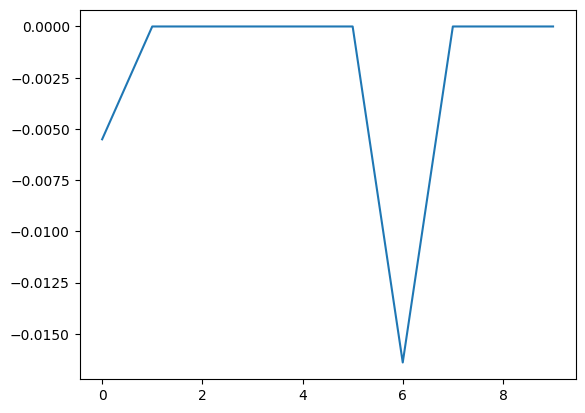

In [12]:
plt.plot(dg_opt1.theta[:,0,1])

## # Generate t with this precision matrix and estimate

In [13]:
# Generate t with this precision matrix and estimate
n = 10000
X1 = mvt.rvs(shape = np.linalg.inv(theta),  df = 4, size = n)
X = X1
X.shape
obs_per_graph = 1000
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 1000, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.2, tol = 1e-6)
dg_opt1.fit(X, nr_workers=10, temporal_penalty="ridge", lik_type="t", nr_em_itr = 100, time_index=range(X.shape[0]), nu = 4, em_tol = 1e-6)
np.sum(np.abs(dg_opt1.theta[0] - theta))/np.sum(np.abs(theta))

Error 1.00E-6:  37%|███▋      | 373/1000 [00:02<00:03, 176.40it/s]


0.28262850077668156

In [14]:
np.sum(np.abs(dg_opt1.theta[0] - theta))/np.sum(np.abs(theta))

0.28262850077668156